---
---
# **Phase 3: Unsupervised Pretraining and Finetuning**
*IS53051A/IS71071B: MACHINE LEARNING*

by Augusta Lina

---

<center>
  <figure>
    <img src="https://i.imgur.com/hGgDCXd.png">
  </figure>
</center>

---
---
# Introduction
---

The notebook consists of Phase 3 and the test set evaluation. In Phase 3 we explore unsupervised pretraining using the unlabelled MRI images and fine tune the model before scaling the number of epochs. We then train the model on the whole training set, before evaluating the model on the test set and visualising the results of the modelling process.

The unsupervised pretraining section included building an autoencoder for unsupervised learning  which trained to a near perfect reconstruction. We then explored different methods for applying the pretrained weights by testing unfrozen weights, using pretraining with warmups, and then running three tests where we adjust the learning rates to better understand the model's response to the pretraining. Next we run two rounds of Kera Tuner. The first round tested different architectural structures by exploring the number of filters and the kernel sizes. The second round tested training parameters by cycling through different options for the learning rate and dropout. The results showed that increasing the model's complexity improved performance but adjusting the training parameters did not.

The best performing model from these rounds was then scaled to 250 epochs using early stopping and model checkpoints to record the best performing epoch. The training and validation sets were then combined and the best performing model was trained until the optimal number of epochs from the previous round and the results evaluated on the test set. The final model achieved a mean DICE score of 0.73 with a fairly even distribution of DICE scores across each segmentation region, with all values being above 0.71. The model achieved a test set F1 Score of 0.75 and a foreground accuracy of 0.68. We then visualise the results by inspecting the worst and best performing samples, and visualise what the kernels learnt at several layers within the network.


<center>
  <figure>
    <img src="https://i.imgur.com/Vv6w1EE.png" , width = 700>
   <figcaption>Visualisation of the feature maps of the convolutional layers from the decoder of the final model.</figcaption>
  </figure>
</center>




---
---
# Set up Environment
----

We set up the basic working environment for the Colab session by first setting the working directory within Google Drive then by downloading the packages and importing the libraries we will be using in this notebook.

In [ ]:
# Import libraries
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Change working directory & Confirm
WORKING_DIR = '/content/drive/My Drive/Studies 2024-25/Goldsmiths/ML/CW2/Directory'
os.chdir(WORKING_DIR)
print("Current working directory:", os.getcwd())

Mounted at /content/drive
Current working directory: /content/drive/My Drive/Studies 2024-25/Goldsmiths/ML/CW2/Directory


---
### Load Libraries
---

In [ ]:
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Model, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

---
---
# Load the Dataset
---

*We load the saved `.npz` compressed files containing the training, validation, and test datasets, including MRI images, segmentation masks, voxel volumes, and grades.

In [ ]:
saveFolder = os.path.join(WORKING_DIR, "Processed2DData")

---
### Supervised Dataset
---

We load the test set in this notebook as well as the validation and training set since we will be evaluating the results.

In [ ]:
# Load .npz files
trainData = np.load(os.path.join(saveFolder, "train.npz"))
valData = np.load(os.path.join(saveFolder, "val.npz"))
testData = np.load(os.path.join(saveFolder, "test.npz"))

In [ ]:
# Extract arrays: Train
XTrain = trainData['X']
YTrainCat = trainData['Y']
voxelTrain = trainData['voxelVolumes']

In [ ]:
# Extract arrays: Validation
XVal = valData['X']
YValCat = valData['Y']
voxelVal = valData['voxelVolumes']

In [ ]:
# Extract arrays: Test
XTest = testData['X']
YTestCat = testData['Y']
voxelTest = testData['voxelVolumes']

In [ ]:
# Confirm load
print(f"Training set: {XTrain.shape}")
print(f"Validation set: {XVal.shape}")
print(f"Test set: {XTest.shape}")

Training set: (1287, 128, 128, 3)
Validation set: (277, 128, 128, 3)
Test set: (276, 128, 128, 3)


---
### Unsupervised Dataset
---

In [ ]:
unlabelledData = np.load(os.path.join(WORKING_DIR, "XUnlabelled.npz"))
XUnlabelled = unlabelledData["XUnlabelled"]

In [ ]:
XUnlabelled.shape

(620, 128, 128, 3)

----
---
# Define Custom Functions
---

In this section we define the custom functions which we first used in the  Phase 1 notebook. For detailed explanations of the below functions please see `1. Phase 1: Baseline Model & Loss Functions.ipynb`. The function defined are  the DICE loss function, the functions for calculating and displaying the evaluation metrics, and a function for displaying the training logs. The evaluation metric functions exclude the background class from the calculations so that the metrics reflect the models' ability to discriminate the tumour regions.

---
### Dice Loss Function
---

In Phase 3 we set the default alpha value to 0.9 instead of applying the anonymous lambda function directly inside the compiler.

In [ ]:
def combinedLoss(yTrue, yPred, alpha=0.9, smooth=1e-6):
    yTrueFlat = K.reshape(yTrue, (-1, 4))
    yPredFlat = K.reshape(yPred, (-1, 4))
    diceLossValue = 0
    for c in range(1, 4):
        yt = yTrueFlat[:, c]
        yp = yPredFlat[:, c]
        intersection = K.sum(yt * yp)
        union = K.sum(yt) + K.sum(yp)
        dice = (2. * intersection + smooth) / (union + smooth)
        diceLossValue += 1 - dice
    diceLossValue /= 3

    ceLossValue = tf.keras.losses.categorical_crossentropy(yTrue, yPred)

    return alpha * diceLossValue + (1 - alpha) * tf.reduce_mean(ceLossValue)

---
### Dice Score Table
---

In [ ]:
def diceScore(yTrue, yPred, modelName="Name", smooth=1e-6):
    yTrueFlat = tf.cast(tf.reshape(yTrue, (-1, 4)), dtype=tf.float64)
    yPredFlat = tf.cast(tf.reshape(yPred, (-1, 4)), dtype=tf.float64)

    diceScores = []
    for c in range(1, 4):
        intersection = tf.reduce_sum(yTrueFlat[:, c] * yPredFlat[:, c])
        union = tf.reduce_sum(yTrueFlat[:, c]) + tf.reduce_sum(yPredFlat[:, c])
        dice = (2. * intersection + smooth) / (union + smooth)
        diceScores.append(dice.numpy())

    meanDice = np.mean(diceScores)

    summaryTable = pd.DataFrame({"Mean": [meanDice], "1 Necrotic Core": [diceScores[0]],
        "2 Edema": [diceScores[1]], "3 Enhancing Tumour": [diceScores[2]],}, index=[modelName])
    return summaryTable.round(4)

---
### Classification Metrics Table
---

In [ ]:
def classMets(yTrue, yPred, modelName="Name"):
    yTrueLabels = np.argmax(yTrue, axis=-1).flatten()
    yPredLabels = np.argmax(yPred, axis=-1).flatten()
    nonBackgroundMask = yTrueLabels > 0
    yTrueNB = yTrueLabels[nonBackgroundMask]
    yPredNB = yPredLabels[nonBackgroundMask]

    precision = precision_score(yTrueNB, yPredNB, labels=[1, 2, 3], average='macro', zero_division=0)
    recall = recall_score(yTrueNB, yPredNB, labels=[1, 2, 3], average='macro', zero_division=0)
    f1 = f1_score(yTrueNB, yPredNB, labels=[1, 2, 3], average='macro', zero_division=0)
    accuracy = accuracy_score(yTrueNB, yPredNB)

    summaryTable = pd.DataFrame({"Macro Precision": [precision],
        "Macro Recall": [recall],
        "Macro F1": [f1],
        "Accuracy (No Background)": [accuracy]}, index=[modelName])

    return summaryTable.round(4)

---
### Training Curves
---

In [ ]:
def plotHist(history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # Loss
    axs[0].plot(history.history['loss'], label="Training Loss")
    axs[0].plot(history.history['val_loss'], label="Validation Loss")
    axs[0].set_title("Training vs Validation Loss")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)
    # Accuracy
    axs[1].plot(history.history['accuracy'], label="Training Accuracy")
    axs[1].plot(history.history['val_accuracy'], label="Validation Accuracy")
    axs[1].set_title("Training vs Validation Accuracy")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

---
---
#  Unsupervised Pretraining
---

In this section we explore a two-stage and three-stage transfer learning framework for unsupervised pretraining using an autoencoder. We train a convolutional autoencoder to reconstruct the input MRI image and the weights from the encoder are used to initialise the weights of the pretrained model. We then explore a two-stage process where the model is able to adjust all the weights during training. This is followed by a three-stage process which includes a warmup round where the weights are frozen for 25 epochs before being unfrozen. The intention behind pretraining is to explore whether we might be able to extract meaningful information from the 620 unlabelled instances which were generated from 126 patients with unlabelled data.

Unsupervised learning is a machine learning process where models learn patterns within the data without the use of labels. Autoencoders are a neural network which learns to compress and reconstruct data. They comprise of an encoder which compresses the input into lower-dimensional space and a decoder which reconstructs the input from its latent representation. The autoencoder is trained to minimise the reconstruction loss between the original input and the output. By downsampling and then having the model reconstruct the data, the model learns useful representations about the data. The convolutional autoencoder below is trained to reconstruct the input MRI image and the weights from the encoder are used to initialise the weights of the pretrained model.

---
## Define and Compile
----

When building the autoencoder and models which receive the pretrained weights, we create separate functions for the encoder and decoder. This is because the encoder is designed to have the same structure as the U-Net model from Phase 2 so that the weights from the encoder can be transferred to the model's encoder. This allows us to call the same function after pretraining.

### Define Encoder

In [ ]:
def encoder_(inputShape=(128, 128, 3)):
    inputs = layers.Input(shape=inputShape)
    # Block 1
    x = layers.Conv2D(32, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.SpatialDropout2D(0.1)(x)
    p1 = layers.MaxPooling2D()(x)
    # Block 2
    x = layers.Conv2D(64, 3, padding='same')(p1)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.SpatialDropout2D(0.1)(x)
    p2 = layers.MaxPooling2D()(x)
    # Block 3
    x = layers.Conv2D(128, 3, padding='same')(p2)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.SpatialDropout2D(0.1)(x)
    p3 = layers.MaxPooling2D()(x)

    return keras.Model(inputs, p3, name="encoder")

### Define Decoder

In [ ]:
def decoder_(encodedInput):
    # Up 1
    x = layers.UpSampling2D()(encodedInput)
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    # Up 2
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    # Up 3
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(32, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    # Output layer
    decoded = layers.Conv2D(3, 1, activation='sigmoid')(x)
    return decoded

### Construct Autoencoder

When building the model, we call the encoder function then the decoder with the output of the encoder as its input. The inputs of the encoder are set to the model input and the outputs are set to the decoder output.

In [ ]:
encoder = encoder_()
decoder_output = decoder_(encoder.output)
autoencoder = keras.Model(encoder.input, decoder_output, name="autoencoder")

The autoencoder consists of 334,083 trainable parameters in total. We compile the model using the Adam optimiser, a learning rate of 1e-4 and a mean squared error (MSE) loss function. The function will also track the mean absolute error (MAE).

In [ ]:
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_3             │ (None, 128, 128, 32)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_4             │ (None, 64, 64, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_5             │ (None, 32, 32, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 334,979 (1.28 MB)

 Trainable params: 334,083 (1.27 MB)

 Non-trainable params: 896 (3.50 KB)

---
## Train
---

We create a folder to save the checkpoints for Phase 3 and create the save path for the unsupervised model.

In [ ]:
saveFolder = os.path.join(WORKING_DIR, "saved_models_phase3")
os.makedirs(saveFolder, exist_ok=True)
savePath = os.path.join(saveFolder, "encoder_autoencoder.weights.h5")

We create the callbacks using early stopping and model checkpoints.

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=savePath,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=0)

earlyStopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=0)

Since the unsupervised dataset does not have a validation set, we create one which the model will use to update its weights during training.

In [ ]:
# Split small validation set from XUnlabelled
XTrainAE, XValAE = train_test_split(XUnlabelled, test_size=0.1, random_state=100)

We train the model for 100 epochs with a batch size of 16.

In [ ]:
# Train
aeHistory = autoencoder.fit(x=XTrainAE,
    y=XTrainAE,
    validation_data=(XValAE, XValAE),
    batch_size=16,
    epochs=100,
    callbacks=[checkpoint, earlyStopping],
    verbose=0)

---
## Evaluate
---

The training logs show a smooth curved decrease which plateaus but does not overfit.

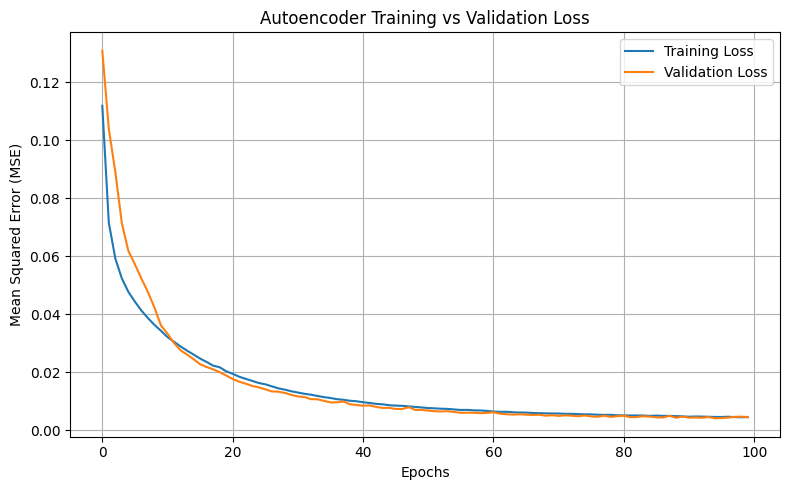

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(aeHistory.history['loss'], label='Training Loss')
plt.plot(aeHistory.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The model achieved a MSE close to zero, of 0.0041. It trained for 100 epochs and restored the weights from the 95th epoch.

In [ ]:
print("Val MSE:", np.min(aeHistory.history['val_loss']).round(4))
print("Epochs:", np.argmin(aeHistory.history['val_loss']) + 1)

Val MSE: 0.0041
Epochs: 95


---
---
# Pretraining with Unfrozen Weights
---

---
## Build Model
---

We construct a full U-Net segmentation model using the encoder pretrained in the previous round. All encoder and decoder layers are trainable from the start. The encoder is re-instantiated with the same architecture and then initialised with the pretrained weights. The decoder mirrors the structure from Phase 2.4, using skip connections from each encoder block. We define the encoder using the `encoder_()` function, we then load the weights which were saved during pretraining onto the model and set the weights to trainable.

In [ ]:
encoder = encoder_()
encoder.load_weights(os.path.join(WORKING_DIR, "saved_models_phase3", "encoder_autoencoder.weights.h5"))
encoder.trainable = True

Once the pretrained encoder is loaded, we reapply each layer manually as the skip connections cannot connect to encoder generated in the above code. This allows the skip connections to access the intermediate feature maps c1, c2, c3 which are not exposed when calling the encoder model directly. The `encoder.layers` method extracts the indexed layer with the weight from the encoder above while the decoder portion of this network is built directly using Tensorflow layers as before. The model is wrapped in a custom function because we will use the same architecture for both training rounds.

In [ ]:
def PretrainedUNet(encoder, modelName="name"):
    # encoder
    inputs = encoder.input
    c1 = encoder.layers[1](inputs)
    c1 = encoder.layers[2](c1)
    c1 = encoder.layers[3](c1)
    c1 = encoder.layers[4](c1)
    p1 = encoder.layers[5](c1)

    c2 = encoder.layers[6](p1)
    c2 = encoder.layers[7](c2)
    c2 = encoder.layers[8](c2)
    c2 = encoder.layers[9](c2)
    p2 = encoder.layers[10](c2)

    c3 = encoder.layers[11](p2)
    c3 = encoder.layers[12](c3)
    c3 = encoder.layers[13](c3)
    c3 = encoder.layers[14](c3)
    p3 = encoder.layers[15](c3)
    # Bottleneck
    b = layers.Conv2D(256, 3, padding='same')(p3)
    b = layers.BatchNormalization()(b)
    b = layers.ReLU()(b)
    # Decoder
    u3 = layers.UpSampling2D()(b)
    u3 = layers.Concatenate()([u3, c3])
    u3 = layers.Conv2D(128, 3, padding='same')(u3)
    u3 = layers.BatchNormalization()(u3)
    u3 = layers.ReLU()(u3)

    u2 = layers.UpSampling2D()(u3)
    u2 = layers.Concatenate()([u2, c2])
    u2 = layers.Conv2D(64, 3, padding='same')(u2)
    u2 = layers.BatchNormalization()(u2)
    u2 = layers.ReLU()(u2)

    u1 = layers.UpSampling2D()(u2)
    u1 = layers.Concatenate()([u1, c1])
    u1 = layers.Conv2D(32, 3, padding='same')(u1)
    u1 = layers.BatchNormalization()(u1)
    u1 = layers.ReLU()(u1)

    outputs = layers.Conv2D(4, 1, activation='softmax')(u1)

    return keras.Model(inputs=inputs, outputs=outputs, name=modelName)

We call the `PretrainedUNet()` function to build the model, passing the encoder with trainable weights to the function. In the compiler, we pass the combined loss function directly instead of using an anonymous function to set the lambda value. We compile the model using the Adam optimiser, a learning rate of 1e-4 and track the accuracy metric. These are the standard compiler parameters for Phase 3.

In [ ]:
fullUNet = PretrainedUNet(encoder, "full_finetune_unet")

In [ ]:
fullUNet.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=combinedLoss, metrics=['accuracy'])

---
## Train
---

We initialise the callbacks and set the save path.

In [ ]:
savePathS2 = os.path.join(saveFolder, "full_finetune_unet.weights.h5")

In [ ]:
checkpointS2 = keras.callbacks.ModelCheckpoint(
    filepath=savePathS2,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=0)

earlyStoppingS2 = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True,
    verbose=0)

The model is trained for 50 epochs and a batch size of 16, the standard training parameters for Phase 3.

In [ ]:
histS2 = fullUNet.fit(
    x=XTrain,y=YTrainCat,
    validation_data=(XVal, YValCat),
    batch_size=16,
    epochs=50,
    callbacks=[checkpointS2, earlyStoppingS2],
    verbose=0)

---
## Evaluate
---

The loss function declined steadily before starting to plateau. The validation loss tends to diverge from the training loss as the number of epochs increases but doesn't show signs of overfitting.

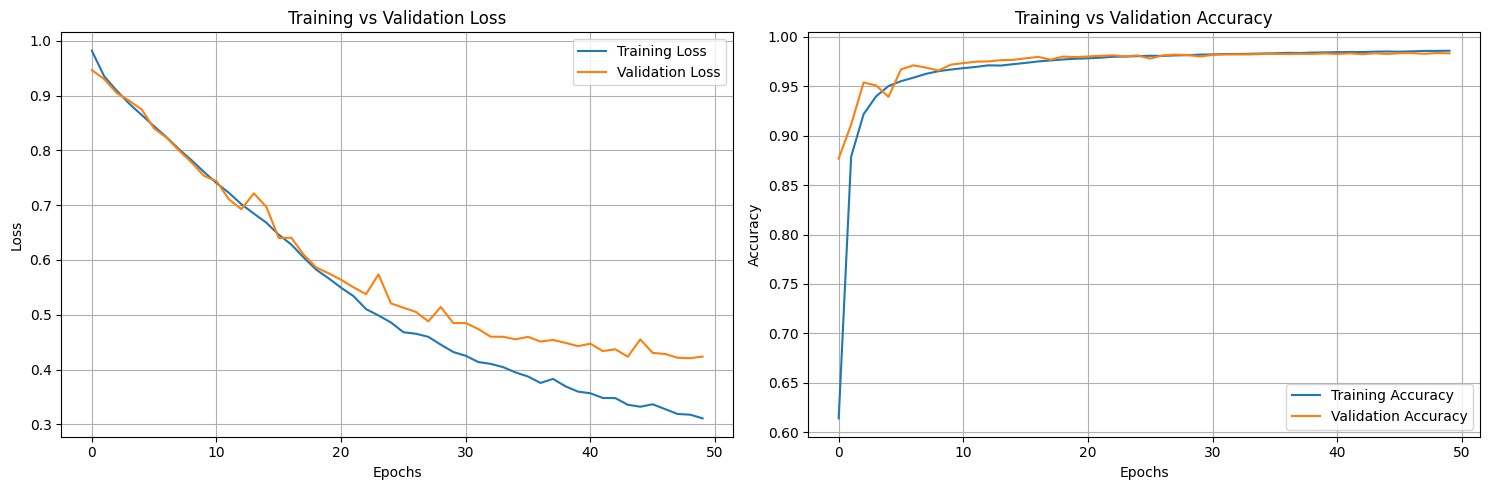

In [ ]:
plotHist(histS2)

We use the restored model to make predictions on the validation set.

In [ ]:
# Predict on validation set
YValPredS2 = fullUNet.predict(XVal)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step


### Transfer Results from Phase 2

We manually add the results of the U-Net model from Phase 2 to a Dataframe which allows us to compare the results of unsupervised pretraining and fine tuning to the results of Phase 2.

In [ ]:
METPhase2 = pd.DataFrame({"Macro Precision":[0.7133],
    "Macro Recall":[0.5648],"Macro F1":[0.6265],
    "Accuracy (No Background)": [0.5704]}, index=["No Pretraining"])

DICEPhase2 = pd.DataFrame({
    "Mean": [0.5637],"1 Necrotic Core": [0.5585],
    "2 Edema":[0.6001],"3 Enhancing Tumour": [0.5325]}, index=["No Pretraining"])

We calculate the DICE scores and macro classification metrics and concatenate them with the table created above.

In [ ]:
DICETableS2 = diceScore(YValCat, YValPredS2, modelName="Pure Pretraining")
METTableS2 = classMets(YValCat, YValPredS2, modelName="Pure Pretraining")

In [ ]:
METTally = pd.concat([METPhase2, METTableS2])
DICETally = pd.concat([DICEPhase2, DICETableS2])

It is difficult to tell whether unsupervised pretraining has improved the model's performance or the results reflect slight random variation in within the training process. The metrics are comparable to the model without pretraining, with the mean DICE score marginally lower at the fourth decimal level and the F1 Score also slightly lower at the fourth decimal level. This may possibly be beacuse of a mismatch between the task of image reconstruction and tumour segmentation and that while they are similar, the model is able to learn the image representation well enough from the existing dataset that additional pretraining for this task does not improve performance.


In [ ]:
DICETally

,Mean,1 Necrotic Core,2 Edema,3 Enhancing Tumour
No Pretraining,0.5637,0.5585,0.6001,0.5325
Pure Pretraining,0.5649,0.5771,0.5823,0.5354


In [ ]:
METTally

,Macro Precision,Macro Recall,Macro F1,Accuracy (No Background)
No Pretraining,0.7133,0.5648,0.6265,0.5704
Pure Pretraining,0.7214,0.5283,0.6059,0.5233


----
----
# Pretraining with Warmup
----

The slightly lower metrics suggests that freezing the layers has slightly hurt performance by preventing the model from learning the segmentation masks.

---
## Build Model
---

We build the model as we did in the previous round, calling the encoder function and loading the weights, except in this round we set the trainable parameter to false. This freezes the weights of the encoder during training.

In [ ]:
encoder = encoder_()
encoder.load_weights(os.path.join(saveFolder, "encoder_autoencoder.weights.h5"))
encoder.trainable = False

We call the function to build the model.

In [ ]:
unetS3 = PretrainedUNet(encoder, modelName="S3_Unet")

We compile the model using the standard Phase 3 compiler parameters.

In [ ]:
unetS3 = buildUNetFromEncoder(encoder, modelName="S3_Unet")

---
## Train
---

We train the model for 25 epochs with a batch size of 16.

### Train Warmup Rounds

In [ ]:
histS3A = unetS3.fit(XTrain, YTrainCat,
    validation_data=(XVal, YValCat),
    epochs=25,
    batch_size=16,
    verbose=0)

The loss showed a steady decline without plateauing. The loss updates started to become unstable as the number of epochs increased.

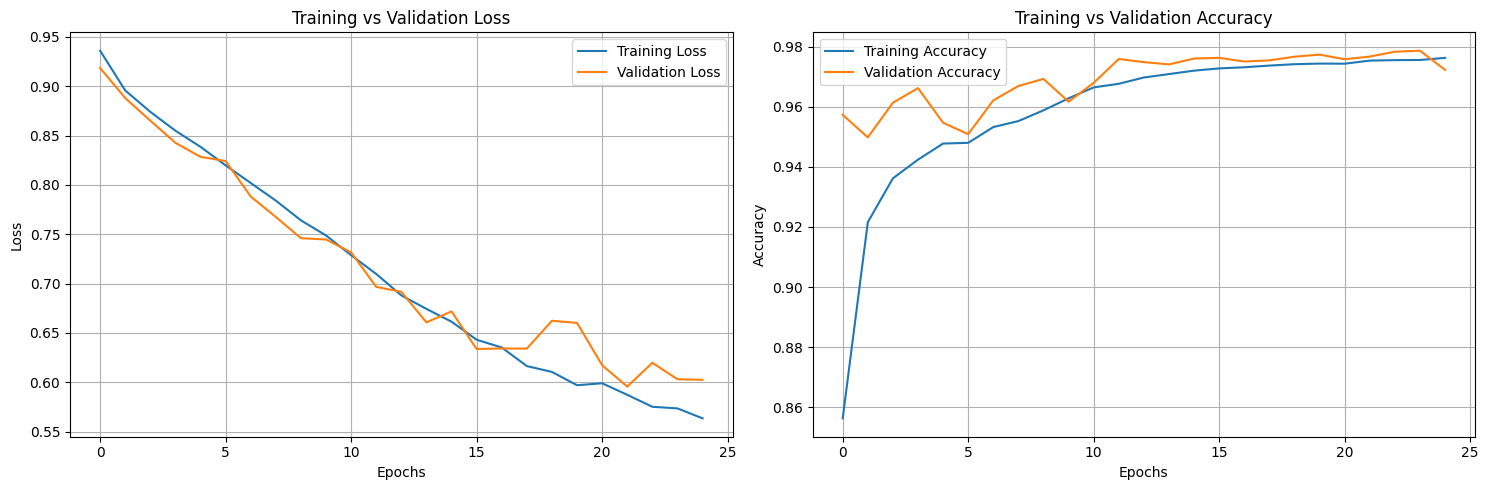

In [ ]:
plotHist(histS3A)

### Unfreeze weights

We unfreeze the weights by setting trainable to true and recompile the model using the same compiler parameters. Then we train the model for 50 epochs, from epoch 25 to epoch 75. Since we freeze the weights during the first 25 epochs, this prevents the model from being penalised for not being able to updates certain weights during the warmup phase and creates a more even comparison between models.

In [ ]:
encoder.trainable = True
unetS3.compile(optimizer=keras.optimizers.Adam(1e-4), loss=combinedLoss, metrics=['accuracy'])

In [ ]:
histS3B = unetS3.fit(XTrain, YTrainCat,
    validation_data=(XVal, YValCat),
    initial_epoch=25,
    epochs=75,
    batch_size=16,
    verbose=0)

The validation loss is significantly greater than the training loss however the model does not show signs of overfitting. The validation accuracy also improves at a slower rate compared to the training accuracy.

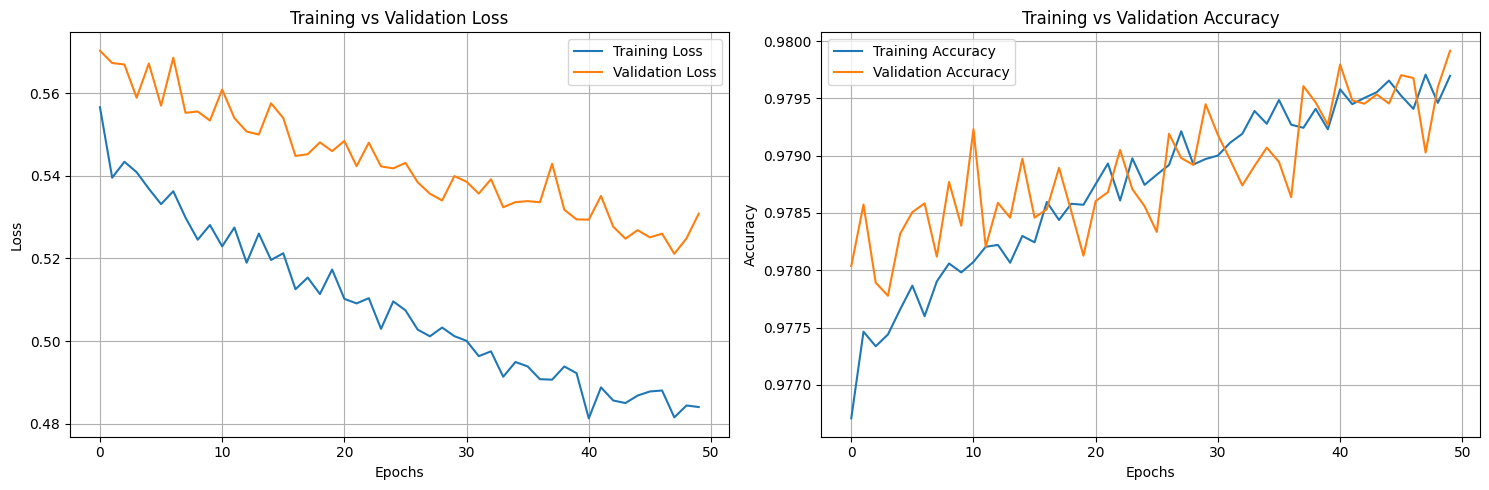

In [ ]:
plotHist(histS3B)

---
## Evaluate
---

We sequentially combine the histories from the warmup and the main training portion to plot the full training logs for this round. The results show some instability in the training, which we saw in `history S3A`, but the primary trend shows the loss function decreasing before starting to plateau.

In [ ]:
# loss histories from S3A and S3B
histS3 = {}
for key in histS3A.history:
    histS3[key] = histS3A.history[key] + histS3B.history[key]

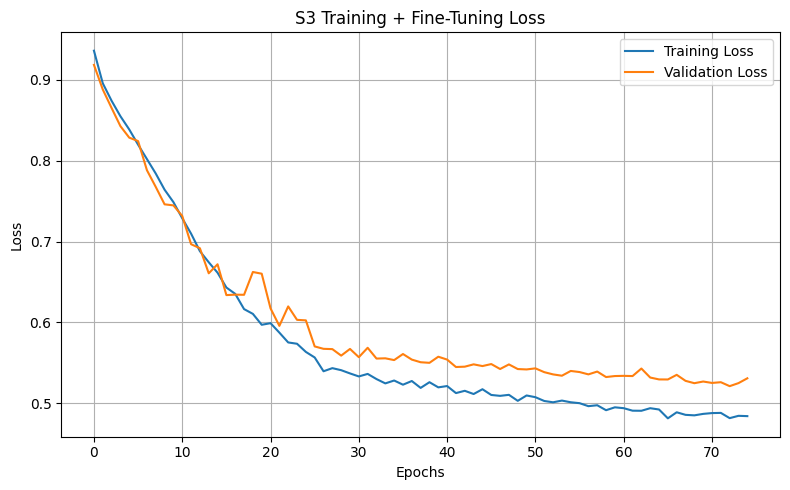

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(histS3["loss"], label="Training Loss")
plt.plot(histS3["val_loss"], label="Validation Loss")
plt.title("S3 Training + Fine-Tuning Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Predict & Compute Metrics

In [ ]:
# Predict
YValPredS3 = unetS3.predict(XVal)

# Compute metrics
DICETableS3 = diceScore(YValCat, YValPredS3, modelName="Warm-Up + Pretrain")
METTableS3 = classMets(YValCat, YValPredS3, modelName="Warm-Up + Pretrain")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [ ]:
# Append to cumulative tally
DICETally = pd.concat([DICETally, DICETableS3])
METTally = pd.concat([METTally, METTableS3])

### Pretraining Conclusion

The lower metrics suggest that freezing the layers has slightly hurt performance by preventing the model from learning the segmentation masks. Considering both pretrained models performed comparably or slightly worse than the model without pretraining, despite a loss which was close to zero for the pretrained autoencoder, it is possible that the pretraining introduced bias into the model which the model struggled to unlearn. The DICE loss with a penalty term used to train the models in this research is weighted towards the tumour segmentation regions while the autoencoder is trained on the entire input space. It is possible that because the background and healthy tissue is the majority class by a significant margin, the autoencoder over-trained on the non-tumour regions and this has either biased the weights, which resulted in slightly lower performance, or has not contributed useful information. This might explain why freezing the encoder weights significantly reduced performance, despite the fact that the warmup model was trained for a total of 75 epochs. Considering models which use pretraining suggest that the pretraining does not improve performance and might hurt the model's ability to discriminate between classes, we will not be continuing with pretraining going forward. This approach also holds when considering that the model without pretraining is simpler but achieved a comparable result to the pretrained model without warmup.

In [ ]:
DICETally

,Mean,1 Necrotic Core,2 Edema,3 Enhancing Tumour
No Pretraining,0.5637,0.5585,0.6001,0.5325
Pure Pretraining,0.5649,0.5771,0.5823,0.5354
Warm-Up + Pretrain,0.4402,0.3726,0.5257,0.4223


In [ ]:
METTally

,Macro Precision,Macro Recall,Macro F1,Accuracy (No Background)
No Pretraining,0.7133,0.5648,0.6265,0.5704
Pure Pretraining,0.7214,0.5283,0.6059,0.5233
Warm-Up + Pretrain,0.6587,0.3929,0.4855,0.4360


### Plot Results

To illustrate the comparative performance between the unsupervised and supervised models, we plot the results. As we can see, the results for no pretraining vs. unsupervised pretraining without warmup is comparable with some metrics performaning slightly worse and others better. The differences appear to be a function of random variation in the training process rather than performance.

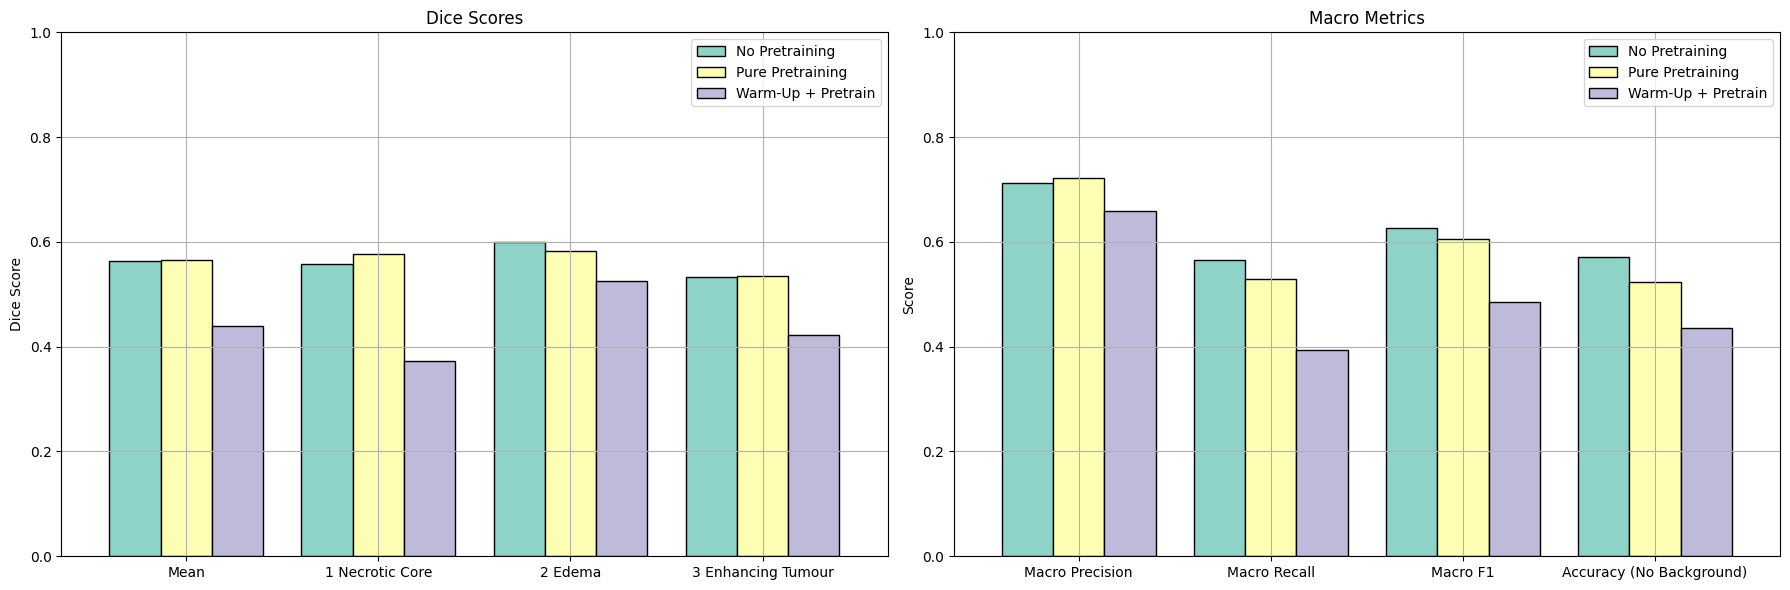

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
# DICE
DICETally.T.plot(kind="bar", ax=axs[0],
    color=cm.Set3.colors[:len(DICETally)],
    edgecolor='black',
    width=0.8)  # wider bars
axs[0].set_title("Dice Scores")
axs[0].set_ylabel("Dice Score")
axs[0].set_ylim(0, 1)
axs[0].tick_params(axis='x', rotation=0)
axs[0].grid(True)
# Metrics
METTally.T.plot(kind="bar", ax=axs[1],
    color=cm.Set3.colors[:len(METTally)],
    edgecolor='black',
    width=0.8)
axs[1].set_title("Macro Metrics")
axs[1].set_ylabel("Score")
axs[1].set_ylim(0, 1)
axs[1].tick_params(axis='x', rotation=0)
axs[1].grid(True)

plt.tight_layout()
plt.show()

---
---
# Fine-tuning: Architecture
---

The model fine tuning rounds are divided into two parts. The first part uses Keras Tuner to fine tune the model architecture by cycling through different values for the kernel sizes and the number of kernels per layer. The second part fine tunes the training parameters by exploring different learning rates and the spatial dropout rate. The results showed that increasing the model's capacity improved performance but adjusting the training parameters did not.

---
## Build Model
---

The number of filters is tuned by allowing the model to cycle through different base filter values. The number of filters changes recursively through the layers by dividing the base value by increasing factors of two. The first encoder layer uses the number of base filters divided by four ($\frac{\text{base filters}}{4}$), while the second uses the number of base filters divided by two ($\frac{\text{base filters}}{2}$). The number of base filters increases recursively through the encoder, then the model uses twice the number of filters for the bottleneck, followed by a recursively decreasing number of filters for the decoder. Here, we test base filter values of 128, 192 and 256. Keras Tuner also explores kernels of size 5x5 vs 3x3 which increases the spatial context of the filters.
Keras Tuner requires us to include the compiler within the hypermodel. We compile each model with the standard compiler parameters for Phase 3 and the DICE loss with a penalty term as the loss function.

We train each model for 50 epochs and a batch size of 16. The results show that the best performing model achieved a validation loss of 0.31.

### Custom HyperModel Class

In [ ]:
class HyperModel1_Architecture(kt.HyperModel):
    def build(self, hp):
        decoderFilters = hp.Choice("decoder_filters", [128, 192, 256])
        kernelSize = hp.Choice("kernel_size", [3, 5])
        inputs = layers.Input(shape=(128, 128, 3))
        # Encoder
        c1 = layers.Conv2D(decoderFilters // 4, kernelSize, padding='same')(inputs)
        c1 = layers.BatchNormalization()(c1)
        c1 = layers.ReLU()(c1)
        c1 = layers.SpatialDropout2D(0.1)(c1)
        p1 = layers.MaxPooling2D()(c1)

        c2 = layers.Conv2D(decoderFilters // 2, kernelSize, padding='same')(p1)
        c2 = layers.BatchNormalization()(c2)
        c2 = layers.ReLU()(c2)
        c2 = layers.SpatialDropout2D(0.1)(c2)
        p2 = layers.MaxPooling2D()(c2)

        c3 = layers.Conv2D(decoderFilters, kernelSize, padding='same')(p2)
        c3 = layers.BatchNormalization()(c3)
        c3 = layers.ReLU()(c3)
        c3 = layers.SpatialDropout2D(0.1)(c3)
        p3 = layers.MaxPooling2D()(c3)
        # Bottleneck
        b = layers.Conv2D(decoderFilters * 2, kernelSize, padding='same')(p3)
        b = layers.BatchNormalization()(b)
        b = layers.ReLU()(b)
        # Decoder
        u3 = layers.UpSampling2D()(b)
        u3 = layers.Concatenate()([u3, c3])
        u3 = layers.Conv2D(decoderFilters, kernelSize, padding='same')(u3)
        u3 = layers.BatchNormalization()(u3)
        u3 = layers.ReLU()(u3)

        u2 = layers.UpSampling2D()(u3)
        u2 = layers.Concatenate()([u2, c2])
        u2 = layers.Conv2D(decoderFilters // 2, kernelSize, padding='same')(u2)
        u2 = layers.BatchNormalization()(u2)
        u2 = layers.ReLU()(u2)

        u1 = layers.UpSampling2D()(u2)
        u1 = layers.Concatenate()([u1, c1])
        u1 = layers.Conv2D(decoderFilters // 4, kernelSize, padding='same')(u1)
        u1 = layers.BatchNormalization()(u1)
        u1 = layers.ReLU()(u1)

        outputs = layers.Conv2D(4, 1, activation='softmax')(u1)

        model = Model(inputs=inputs, outputs=outputs)

        model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
            loss=combinedLoss,
            metrics=["accuracy"])

        return model

### Instantiate and Run Tuner

We instantiate the trainer to run a maximum of six trials and use the validation loss to compare models.

In [ ]:
tuner1 = kt.GridSearch(
    hypermodel=HyperModel1_Architecture(),
    objective="val_loss",
    max_trials=6,
    directory="kt_dir",
    project_name="phase3_decoder_grid")

We set the checkpoints which are used during training.

In [ ]:
savePath_tuneRound1 = os.path.join(saveFolder, "TuneRound1_best.weights.h5")

In [ ]:
checkpoint = ModelCheckpoint(filepath=savePath_tuneRound1,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=0)

earlyStop = EarlyStopping(monitor="val_loss",
    patience=15,
    restore_best_weights=True,
    verbose=0)

---
## Train
---

We train each model for 50 epochs and a batch size of 16. The results show that the best performing model achieved a validation loss of 0.31.

In [ ]:
tuner1.search(XTrain, YTrainCat,
    validation_data=(XVal, YValCat),
    epochs=50,
    batch_size=16,
    callbacks=[checkpoint, earlyStop],
    verbose=1)

Trial 6 Complete [00h 02m 26s]
val_loss: 0.311800092458725

Best val_loss So Far: 0.311800092458725
Total elapsed time: 00h 11m 10s


---
## Evaluate
---

We extract the best performing model from Keras Tuner and use it to make predictions on the validation set.


In [ ]:
bestTuneRound1 = tuner1.get_best_models(num_models=1)[0]
YValPred = bestTuneRound1.predict(XVal, batch_size=16, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


We extract the parameters from the best perfoming model which used 256 filters and its base value and 5x5 kernels, indicating the model has benefited from increased capacity and was underfitting the data.

In [ ]:
bestHPs = tuner1.get_best_hyperparameters(num_trials=1)[0]
print(f"Decoder filters: {bestHPs.get('decoder_filters')}")
print(f"Kernel size: {bestHPs.get('kernel_size')}")

Decoder filters: 256
Kernel size: 5


Fine tuning the architecture and increasing the model's capacity has significantly improved the model's performance. The Macro F1 Score increased to 0.71 from 0.61 and the accuracy metric without background improved from 0.52 to 0.67. The average DICE score increased from 0.56 to 0.68 with improvement gains across all classes.

In [ ]:
DICETally = pd.concat([DICETally, diceScore(YValCat, YValPred, modelName="Finetune Architecture")])
METTally = pd.concat([METTally, classMets(YValCat, YValPred, modelName="Finetune Architecture")])

In [ ]:
METTally

,Macro Precision,Macro Recall,Macro F1,Accuracy (No Background)
No Pretraining,0.7133,0.5648,0.6265,0.5704
Pure Pretraining,0.7214,0.5283,0.6059,0.5233
Warm-Up + Pretrain,0.6587,0.3929,0.4855,0.4360
Finetune Architecture,0.7950,0.6427,0.7105,0.6564


In [ ]:
DICETally

,Mean,1 Necrotic Core,2 Edema,3 Enhancing Tumour
No Pretraining,0.5637,0.5585,0.6001,0.5325
Pure Pretraining,0.5649,0.5771,0.5823,0.5354
Warm-Up + Pretrain,0.4402,0.3726,0.5257,0.4223
Finetune Architecture,0.6801,0.6780,0.7042,0.6582


---
---
# Fine-tune Training Parameters
---

Next we fine tune the model's learning rate and spatial dropout rate. The results showed that tuning the model did not result in a significant improvement.

---
## Build Model
---

We define a hypermodel using the U-Net architecture from Phase 2. The model will cycle through dropout values above and below the current value of 0.1, from 0.05 to 0.2 in steps of 0.05. We cycle through three learning rates of 1e-4, 1e-3 and 1e-2. As before, we instantiate the compiler within the hypermodel using the same parameters as before.



In [ ]:
class HyperModel2_Training(kt.HyperModel):
    def build(self, hp):
        # params from previous tuning round
        decoderFilters = 256
        kernelSize = 5
        # params for tuning in current round
        dropoutRate = hp.Choice("dropout", [0.05, 0.1, 0.15, 0.2])
        learningRate = hp.Choice("learning_rate", [1e-4, 1e-3, 1e-2])

        inputs = layers.Input(shape=(128, 128, 3))
        # Encoder
        c1 = layers.Conv2D(decoderFilters // 4, kernelSize, padding='same')(inputs)
        c1 = layers.BatchNormalization()(c1)
        c1 = layers.ReLU()(c1)
        c1 = layers.SpatialDropout2D(dropoutRate)(c1)
        p1 = layers.MaxPooling2D()(c1)

        c2 = layers.Conv2D(decoderFilters // 2, kernelSize, padding='same')(p1)
        c2 = layers.BatchNormalization()(c2)
        c2 = layers.ReLU()(c2)
        c2 = layers.SpatialDropout2D(dropoutRate)(c2)
        p2 = layers.MaxPooling2D()(c2)

        c3 = layers.Conv2D(decoderFilters, kernelSize, padding='same')(p2)
        c3 = layers.BatchNormalization()(c3)
        c3 = layers.ReLU()(c3)
        c3 = layers.SpatialDropout2D(dropoutRate)(c3)
        p3 = layers.MaxPooling2D()(c3)
        # Bottleneck
        b = layers.Conv2D(decoderFilters * 2, kernelSize, padding='same')(p3)
        b = layers.BatchNormalization()(b)
        b = layers.ReLU()(b)
        # Decoder
        u3 = layers.UpSampling2D()(b)
        u3 = layers.Concatenate()([u3, c3])
        u3 = layers.Conv2D(decoderFilters, kernelSize, padding='same')(u3)
        u3 = layers.BatchNormalization()(u3)
        u3 = layers.ReLU()(u3)
        u3 = layers.SpatialDropout2D(dropoutRate)(u3)

        u2 = layers.UpSampling2D()(u3)
        u2 = layers.Concatenate()([u2, c2])
        u2 = layers.Conv2D(decoderFilters // 2, kernelSize, padding='same')(u2)
        u2 = layers.BatchNormalization()(u2)
        u2 = layers.ReLU()(u2)
        u2 = layers.SpatialDropout2D(dropoutRate)(u2)

        u1 = layers.UpSampling2D()(u2)
        u1 = layers.Concatenate()([u1, c1])
        u1 = layers.Conv2D(decoderFilters // 4, kernelSize, padding='same')(u1)
        u1 = layers.BatchNormalization()(u1)
        u1 = layers.ReLU()(u1)
        u1 = layers.SpatialDropout2D(dropoutRate)(u1)

        outputs = layers.Conv2D(4, 1, activation='softmax')(u1)

        model = Model(inputs, outputs)

        model.compile(optimizer=keras.optimizers.Adam(learning_rate=learningRate),
            loss=combinedLoss,
            metrics=["accuracy"])

        return model

---
## Train
----

### Grid Search Setup

We configure Keras Tuner to run for 12 trials and use the validation loss to define the best performing model.

In [ ]:
tuner2 = kt.GridSearch(hypermodel=HyperModel2_Training(),
    objective="val_loss",
    max_trials=12,
    directory="kt_dir",
    project_name="phase3_grid_lr_dropout")

### Callbacks

In [ ]:
savePath_tuneRound2 = os.path.join(saveFolder, "TuneRound2_best.weights.h5")

In [ ]:
checkpoint = ModelCheckpoint(filepath=savePath_tuneRound2,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=0)

earlyStop = EarlyStopping(monitor="val_loss",
    patience=15,
    restore_best_weights=True,
    verbose=0)

### Fit Model

Keras Tuner took approximately 27 minutes to run all 12 tuning rounds. The best performing validation loss was 0.31.

In [ ]:
tuner2.search(XTrain, YTrainCat,
    validation_data=(XVal, YValCat),
    epochs=50,
    batch_size=16,
    callbacks=[checkpoint, earlyStop],
    verbose=1)

Trial 12 Complete [00h 02m 18s]
val_loss: 0.4140656590461731

Best val_loss So Far: 0.3148009777069092
Total elapsed time: 00h 27m 57s


---
## Evaluate
---

###  Extract the Best Model

In [ ]:
bestTuneRound2 = tuner2.get_best_models(num_models=1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Extract the Hyperparameters

The best performing model from the Keras Tuner round used a learning rate of 1e-3 and and a spatial dropout rate of 0.05.

In [ ]:
bestHPs = tuner2.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
print(f"Dropout rate: {bestHPs.get('dropout')}")
print(f"Learning rate: {bestHPs.get('learning_rate')}")

Dropout rate: 0.05
Learning rate: 0.001


### Evaluate on Validation Set

In [ ]:
YValPred = bestTuneRound2.predict(XVal, batch_size=16, verbose=0)

### Update Metric Tables

The results of the fine tuning are somewhat inconclusive. The standard training parameters of a spatial dropout of 0.1 and learning rate of 1e-4 were included in the tuner search range. However, the tuner selected a dropout value of 0.05 and a learning rate of 1e-3 and yet the results from the tuning round were marginally lower compared to the previous round, which used an identical architecture. This suggests that the difference between these parameters is a factor of random variation within the training process and not the result of parameter differences. Considering the second parameter set slightly underperformed and the first has been a robust set of metrics which we have consistently used across this research, we will continue to use the original training metrics and will not update the parameters going forward.

In [ ]:
DICETally = pd.concat([DICETally, diceScore(YValCat, YValPred, modelName="Finetune Training Params")])
METTally = pd.concat([METTally, classMets(YValCat, YValPred, modelName="Finetune Training Params")])

In [ ]:
DICETally

,Mean,1 Necrotic Core,2 Edema,3 Enhancing Tumour
No Pretraining,0.5637,0.5585,0.6001,0.5325
Pure Pretraining,0.5649,0.5771,0.5823,0.5354
Warm-Up + Pretrain,0.4402,0.3726,0.5257,0.4223
Finetune Architecture,0.6801,0.6780,0.7042,0.6582
Finetune Training Params,0.6765,0.6698,0.6978,0.6619


In [ ]:
METTally

,Macro Precision,Macro Recall,Macro F1,Accuracy (No Background)
No Pretraining,0.7133,0.5648,0.6265,0.5704
Pure Pretraining,0.7214,0.5283,0.6059,0.5233
Warm-Up + Pretrain,0.6587,0.3929,0.4855,0.4360
Finetune Architecture,0.7950,0.6427,0.7105,0.6564
Finetune Training Params,0.7913,0.6503,0.7130,0.6690


### Plot Comparative Results

We plot the results of the training rounds. As we can see the training parameter finetuning round slightly underperformed compared to the previous round.

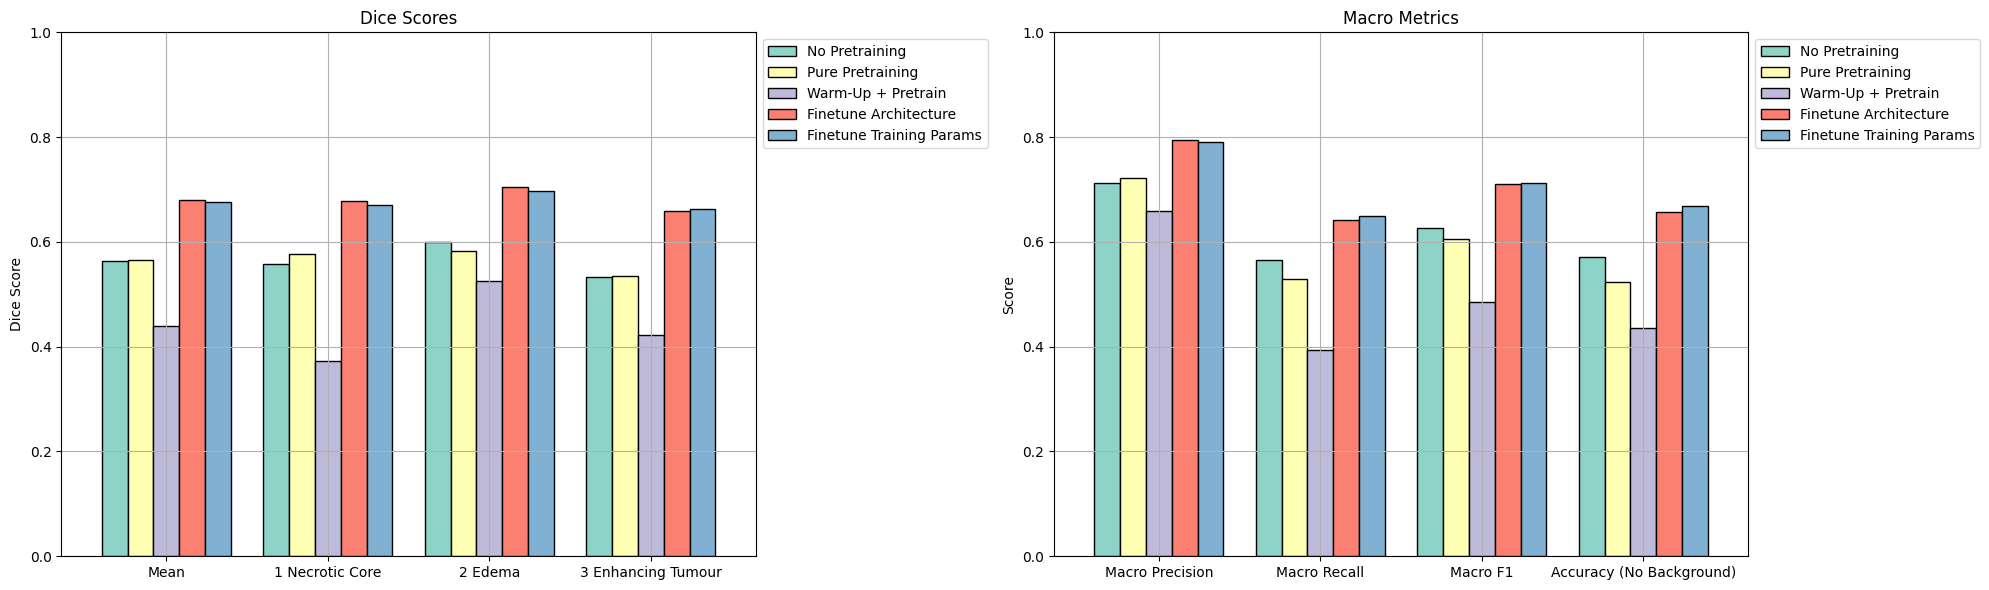

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
#DICE
DICETally.T.plot(kind="bar", ax=axs[0],
    color=cm.Set3.colors[:len(DICETally)],
    edgecolor='black',
    width=0.8)
axs[0].set_title("Dice Scores")
axs[0].set_ylabel("Dice Score")
axs[0].set_ylim(0, 1)
axs[0].tick_params(axis='x', rotation=0)
axs[0].grid(True)
axs[0].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
#mets
METTally.T.plot(kind="bar", ax=axs[1],
    color=cm.Set3.colors[:len(METTally)],
    edgecolor='black',
    width=0.8)
axs[1].set_title("Macro Metrics")
axs[1].set_ylabel("Score")
axs[1].set_ylim(0, 1)
axs[1].tick_params(axis='x', rotation=0)
axs[1].grid(True)
axs[1].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.tight_layout()
plt.show()

---
---
# Train Best Model Until Convergence
---

Now that we have established a good model architecture and training configuration, we scale up the number of epochs during training.

---
### Build & Compile Model
---

We define a function called `finalModel()` which contains the complete final architecture we will use for the remainder of this research. It uses the U-Net model defined in Phase 2 and the parameters we defined in the previous two training rounds.

In [ ]:
def finalModel():
   # params
    decoderFilters = 256
    kernelSize = 5
    dropoutRate = 0.1
    learningRate = 0.001
    # model
    inputs = layers.Input(shape=(128, 128, 3))
    # Encoder
    c1 = layers.Conv2D(decoderFilters // 4, kernelSize, padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.ReLU()(c1)
    c1 = layers.SpatialDropout2D(dropoutRate)(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(decoderFilters // 2, kernelSize, padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.ReLU()(c2)
    c2 = layers.SpatialDropout2D(dropoutRate)(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(decoderFilters, kernelSize, padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.ReLU()(c3)
    c3 = layers.SpatialDropout2D(dropoutRate)(c3)
    p3 = layers.MaxPooling2D()(c3)
    # Bottleneck
    b = layers.Conv2D(decoderFilters * 2, kernelSize, padding='same')(p3)
    b = layers.BatchNormalization()(b)
    b = layers.ReLU()(b)
    # Decoder
    u3 = layers.UpSampling2D()(b)
    u3 = layers.Concatenate()([u3, c3])
    u3 = layers.Conv2D(decoderFilters, kernelSize, padding='same')(u3)
    u3 = layers.BatchNormalization()(u3)
    u3 = layers.ReLU()(u3)
    u3 = layers.SpatialDropout2D(dropoutRate)(u3)

    u2 = layers.UpSampling2D()(u3)
    u2 = layers.Concatenate()([u2, c2])
    u2 = layers.Conv2D(decoderFilters // 2, kernelSize, padding='same')(u2)
    u2 = layers.BatchNormalization()(u2)
    u2 = layers.ReLU()(u2)
    u2 = layers.SpatialDropout2D(dropoutRate)(u2)

    u1 = layers.UpSampling2D()(u2)
    u1 = layers.Concatenate()([u1, c1])
    u1 = layers.Conv2D(decoderFilters // 4, kernelSize, padding='same')(u1)
    u1 = layers.BatchNormalization()(u1)
    u1 = layers.ReLU()(u1)
    u1 = layers.SpatialDropout2D(dropoutRate)(u1)

    outputs = layers.Conv2D(4, 1, activation='softmax')(u1)
    model = Model(inputs, outputs, name="modelforConvergence")
    return model

We build the model and compile it using a learning rate of 1e-4, the DICE loss with a penalty term and an Adam optimiser.

In [ ]:
modelConverge = finalModel()

modelConverge.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                      loss=combinedLoss,metrics=["accuracy"])

---
## Train
---

In [ ]:
savePath_bestConverge = os.path.join(saveFolder, "BestModel_Converged.weights.h5")

The patience for early stopping is set to 15 and restore best weights is set to true.

In [ ]:
checkpointConverge = ModelCheckpoint(filepath=savePath_bestConverge,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    verbose=0)

earlyStopConverge = EarlyStopping(monitor="val_loss",
    patience=15,
    restore_best_weights=True,
    verbose=0)

We train the model to 250 epochs using a batch size of 16.

In [ ]:
histConverge = modelConverge.fit(XTrain, YTrainCat,
    validation_data=(XVal, YValCat),
    epochs=250,
    batch_size=16,
    callbacks=[checkpointConverge, earlyStopConverge],
    verbose=0)

---
## Evaluate
---

The model trained for approximately 124 epochs before stopping with the best performing epoch being epoch 114. It achieved a validation loss of 0.259. The training curves show the model started to plateau after approximately 50 epochs and that training was initially unstable but started to smooth as the number of epochs increased. While the validation loss is significantly higher than the training loss, the model does not show signs of overfitting.

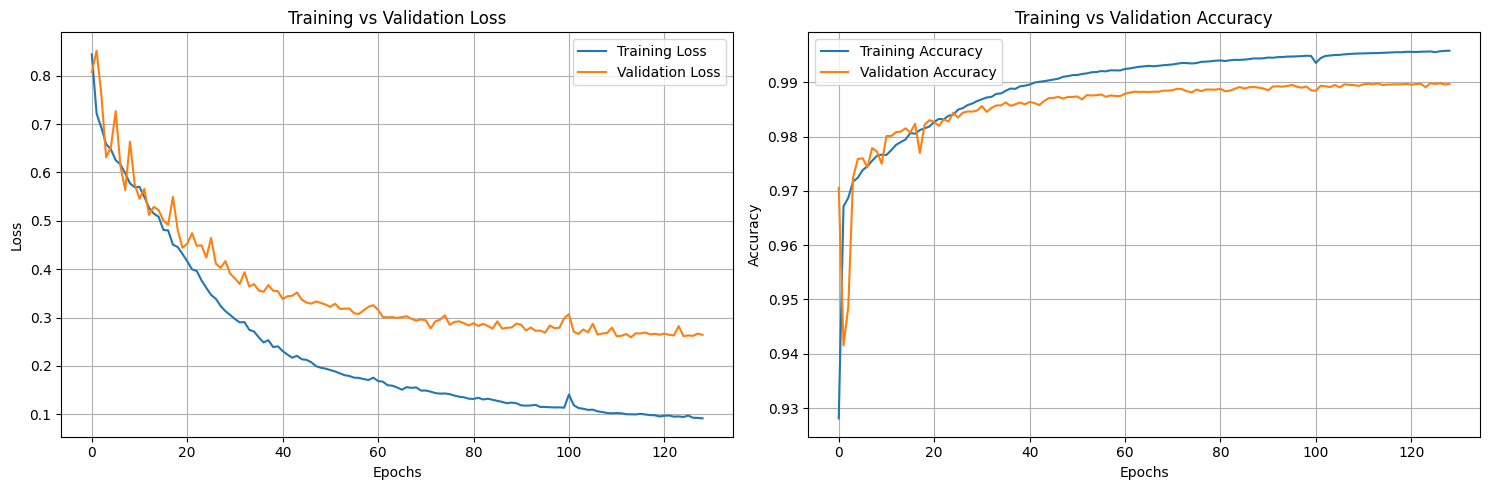

In [ ]:
plotHist(histConverge)

In [ ]:
bestValLoss = np.min(histConverge.history["val_loss"])
bestEpoch = np.argmin(histConverge.history["val_loss"]) + 1

print(f"Best Validation Loss: {bestValLoss:.4f}")
print(f"Best Epoch: {bestEpoch}")

Best Validation Loss: 0.2592
Best Epoch: 114


In [ ]:
YValPred = modelConverge.predict(XVal, batch_size=16, verbose=0)

In [ ]:
DICETally = pd.concat([DICETally, diceScore(YValCat, YValPred, modelName="Converged Model")])
METTally = pd.concat([METTally, classMets(YValCat, YValPred, modelName="Converged Model")])

Increasing the training from 50 to 250 epochs has improved the model's performance. Training the model for longer has allowed the model to learn more information about the underlying structure within the data. The Macro F1 score increased to 0.76 while the accuracy without background increased to 0.7, meaning that 70% of the tumour pixel regions have been correctly classified. The model achieved a mean DICE score of 0.74 which reflects that the model is able to achieve fairly good overlap between the actual and predicted tumour regions at the pixel level.

In [ ]:
METTally

,Macro Precision,Macro Recall,Macro F1,Accuracy (No Background)
No Pretraining,0.7133,0.5648,0.6265,0.5704
Pure Pretraining,0.7214,0.5283,0.6059,0.5233
Warm-Up + Pretrain,0.6587,0.3929,0.4855,0.4360
Finetune Architecture,0.7950,0.6427,0.7105,0.6564
Finetune Training Params,0.7913,0.6503,0.7130,0.6690
Converged Model,0.8418,0.6987,0.7632,0.7033


In [ ]:
DICETally

,Mean,1 Necrotic Core,2 Edema,3 Enhancing Tumour
No Pretraining,0.5637,0.5585,0.6001,0.5325
Pure Pretraining,0.5649,0.5771,0.5823,0.5354
Warm-Up + Pretrain,0.4402,0.3726,0.5257,0.4223
Finetune Architecture,0.6801,0.6780,0.7042,0.6582
Finetune Training Params,0.6765,0.6698,0.6978,0.6619
Converged Model,0.7422,0.7484,0.7522,0.7261


### Plot Results

By plotting the results we can see that the converged model has improved upon the previous rounds, however, the improvements are moderate relative to the increase in the number of epochs.

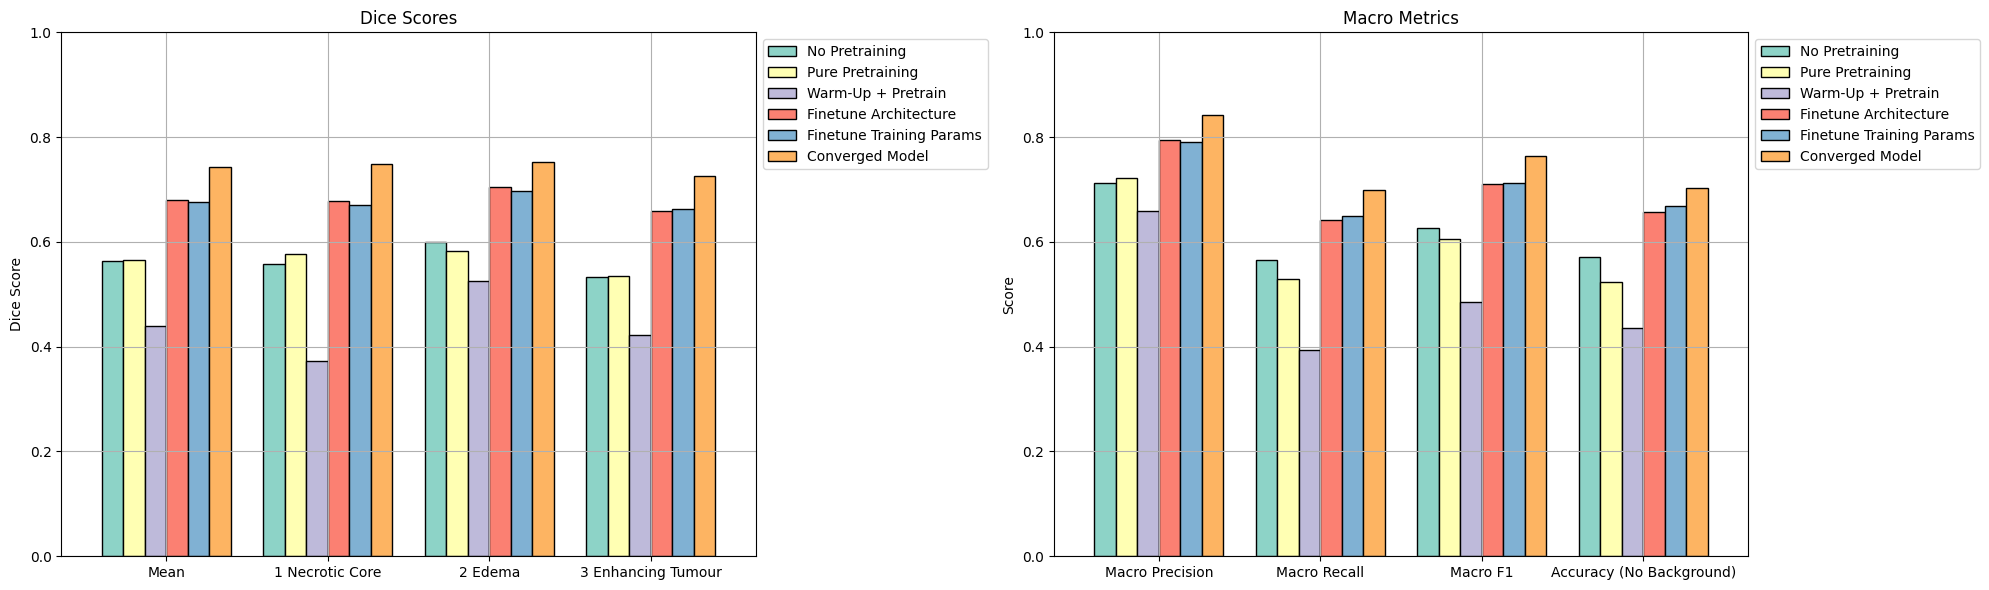

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
# Dice Scores
DICETally.T.plot(kind="bar", ax=axs[0],
    color=cm.Set3.colors[:len(DICETally)],
    edgecolor='black',
    width=0.8)
axs[0].set_title("Dice Scores")
axs[0].set_ylabel("Dice Score")
axs[0].set_ylim(0, 1)
axs[0].tick_params(axis='x', rotation=0)
axs[0].grid(True)
axs[0].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
# Metrics
METTally.T.plot(kind="bar", ax=axs[1],
    color=cm.Set3.colors[:len(METTally)],
    edgecolor='black',
    width=0.8)
axs[1].set_title("Macro Metrics")
axs[1].set_ylabel("Score")
axs[1].set_ylim(0, 1)
axs[1].tick_params(axis='x', rotation=0)
axs[1].grid(True)
axs[1].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.tight_layout()
plt.show()

---
---
# Retrain the Best Performing Model on the Full Training Set
---

In this round we merge the training and validation sets and train the model for the best performing number of epochs, 114, before evaluating the model on the test set. By merging the datasets, the model has the opportunity to learn a greater amount of detail about the underlying patterns in the data.

---
## Build & Compile Model
---

### Merge Validation & Training Set

In [ ]:
XFull = np.concatenate([XTrain, XVal], axis=0)
YFull = np.concatenate([YTrainCat, YValCat], axis=0)

### Rebuild Model

We build the model by calling the `finalModel()` function and compile it using a learning rate of 1e-4, the DICE loss with a penalty term and an Adam optimiser.

In [ ]:
evalModel = finalModel()
evalModel.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                      loss=combinedLoss,metrics=["accuracy"])

---
## Train
---

We set the save path and train the model for 114 epochs and a batch size of 16. We specify the merged dataset for the model to train on.

In [ ]:
savePath_evalModel = os.path.join(saveFolder, "BestModel_Retrained.weights.h5")

In [ ]:
histEvalModel= evalModel.fit(XFull, YFull,
    epochs=114,
    batch_size=16,
    verbose=0)

---
## Evaluate
---

Save the model weights.

In [ ]:
evalModel.save_weights(savePath_evalModel)

### Predict on the Test Set & Final Interpretation

We use the trained model to make predictions on the test set and then generate the DICE and macro classification metrics from the results. The model achieved a mean DICE score of 0.73, which suggests good segmentation across all tumour subregions. The average DICE score across all three tumour classes was 0.73, indicating a good overlap between the model's predictions and the human-annotated segmentations. The model performs best at predicting edema, swelling around the tumour, but still shows strong predictive capacity at identifying the necrotic core and enhancing tumour with a DICE score of 0.73 and 0.72, respectively, for these regions. The precision is much higher compared to the recall, suggesting the model tends to be correct when it predicts a tumour region, but tends to incorrectly classify approximately 34% of tumour regions. This trade-off is reflected in the F1 Score of 0.75. The model achieved an accuracy of 0.68 on the foreground elements, meaning it correctly predicts approximately 68% of tumour regions.

The model demonstrates good predictive performance however, the margin of error is large enough that the model would not be a reliable sole indicator of tumour regions and would not be suitable for replacing human interpretation. However, such performance could be a useful second opinion or reference used by experts to validate their assumptions. The model's performance would be significantly improved if the model were trained on the full 3D model as if we consider we are working with five slices from approximately 429 slices per image (when accounting for the three perspective planes) this means the model is generating a prediction with approximately 1.1% of the information available. However, 3D modelling is computationally expensive and beyond the scope of the resources available in this research.

In [ ]:
YTestPred = evalModel.predict(XTest, batch_size=16, verbose=0)

In [ ]:
DICETest = diceScore(YTestCat, YTestPred, modelName="Test Set")

In [ ]:
DICETest

,Mean,1 Necrotic Core,2 Edema,3 Enhancing Tumour
Test Set,0.7344,0.7262,0.7587,0.7184


In [ ]:
classMetsTest = classMets(YTestCat, YTestPred, modelName="Test Set")

In [ ]:
classMetsTest

,Macro Precision,Macro Recall,Macro F1,Accuracy (No Background)
Test Set,0.8582,0.6635,0.7482,0.6781


---
---
# Inspect the Results
---

Using the same method as in Phase 1, we inspect the two best and worst performing samples to see how the model has progressed and to better understand how the model might be performing. First we turn the model's predictions from a probability distribution into one hot encoded masks.

In [ ]:
def oneHotMask(maskSoftmax):
    classIndices = np.argmax(maskSoftmax, axis=-1)
    oneHotMask = np.eye(4)[classIndices]
    return oneHotMask

We calculate the mean DICE score for each sample in the dataset. This allows us to select the best and worst performing samples.

In [ ]:
def sampleDice(yTrue, yPred, smooth=1e-6):
    scores = []
    for i in range(yTrue.shape[0]):
        diceList = []
        for c in range(1, 4):
            yt = yTrue[i, ..., c].flatten()
            yp = yPred[i, ..., c].flatten()
            intersection = np.sum(yt * yp)
            union = np.sum(yt) + np.sum(yp)
            dice = (2. * intersection + smooth) / (union + smooth)
            diceList.append(dice)
        scores.append((i, np.mean(diceList)))
    return scores

Using the same process as in Phase 1, we create a semi-transpartent colour map for the segmentaion masks and greyscale the MRIs. This function allows us to plot the MRIs with the predicted and actual probability masks.

In [ ]:
def plotSample(mri, trueMask, predMask, title_prefix=""):
    colours = [(0, 0, 0, 0), (1, 0, 0, 0.6), (0, 1, 0, 0.6), (1, 1, 0, 0.6)]
    customCmap = ListedColormap(colours)

    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    axs[0].imshow(mri.T, cmap="gray", origin="lower")
    axs[0].set_title("MRI Slice", fontsize=10)
    axs[0].axis("off")

    axs[1].imshow(mri.T, cmap="gray", origin="lower")
    axs[1].imshow(trueMask.T, cmap=customCmap, origin="lower", alpha=0.5)
    axs[1].set_title("Ground Truth Overlay", fontsize=10)
    axs[1].axis("off")

    axs[2].imshow(mri.T, cmap="gray", origin="lower")
    axs[2].imshow(predMask.T, cmap=customCmap, origin="lower", alpha=0.5)
    axs[2].set_title("Prediction Overlay", fontsize=10)
    axs[2].axis("off")

    fig.suptitle(title_prefix, fontsize=10)
    plt.tight_layout()
    plt.show()

Not every MRI slice contains tumour regions, therefore we exclude samples which do not contain affected areas.

In [ ]:
validIndices = [i for i in range(YTestCat.shape[0])
    if np.sum(np.argmax(YTestCat[i], axis=-1) > 0) > 0]

We call the per sample DICE score function on the selected samples.

In [ ]:
diceScores = []
for i in validIndices:
    score = sampleDice(YTestCat[i:i+1], YTestPred[i:i+1])[0][1]
    diceScores.append((i, score))

Next, we filter the best and worst performing samples, defined by their DICE score.

In [ ]:
sortedScores = sorted(diceScores, key=lambda x: x[1])
worst = sortedScores[:2]
best = sortedScores[-2:]

### Interpretation of Worst Performing Examples

By inspecting the worst-performing instances, we can see the same pattern as we did for the baseline model. The final model struggles to predict regions that are very small or not very pronounced. For example, in the second worst case, with a DICE score of 0.0003, the number of pixels in the tumour regions is so small that we cannot see the mask with the naked eye. However, these small regions tend to be the edge of larger, pronounced tumour regions. They are indistinguishable when viewed as a slice, but when viewed as a 3D visualisation, it would be much easier to identify. Since tumour boundaries tend to show as a gradation of colour on MRI scans, the challenge of the worst performing slices is not only that they consist of a few pixel regions, but they are likely also a shade that very closely matches healthy tissue. This is possibly why the model struggled to predict the worst performing example where the edema region, shown in green, is also fairly difficult to identify with the naked eye. This challenge would probably be best handled by feeding a model contextualised slices rather than individual images, such as creating a dataset where several slices are stacked into shallow 3D regions, in instances where processing a full MRI is not feasible due to resource constraints.

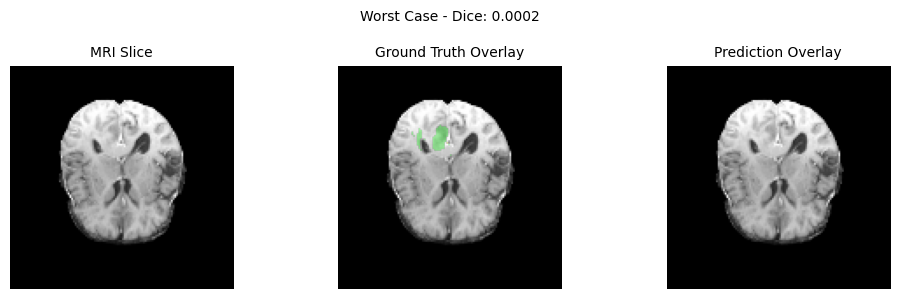

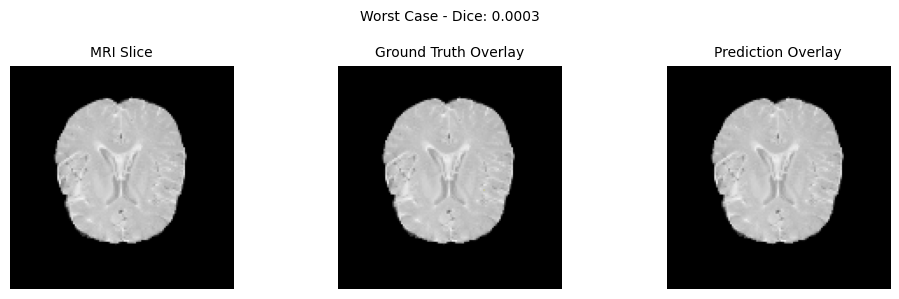

In [ ]:
for idx, score in worst:
    mri = XTest[idx]
    trueMask = np.argmax(YTestCat[idx], axis=-1)
    predMask = np.argmax(YTestPred[idx], axis=-1)
    if mri.ndim == 3 and mri.shape[-1] == 3:
        mri = np.mean(mri, axis=-1)
    plotSample(mri, trueMask, predMask, f"Worst Case - Dice: {score:.4f}")

### Interpretation of Best Performing Examples

The model has significantly improved in its ability to discriminate between tumour regions compared to the baseline model. Below is an image comparing the the results of the best performing instances for the baseline model. As we can see, the model is able to identify when an area is not healthy tissue but it is not able to effectively discriminate between different tumour regions. In contrast, the final model has produced fairly accurate segmentation boundaries which can identify tumour areas and the specific subregions of the affected sites.

<center>
  <figure>
    <img src="https://i.imgur.com/aoqCtz6.png2", width=400 >
   <figcaption> Side by side comparisons of the raw MRI image, the human-annotated mask and the mask the baseline model in Phase 1 predicted.</figcaption>
   </figure>
</center>



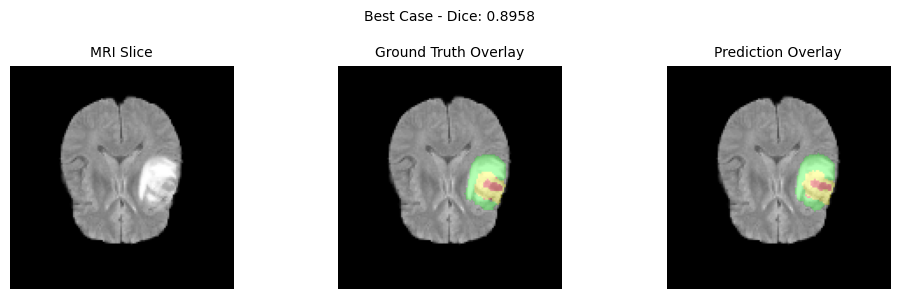

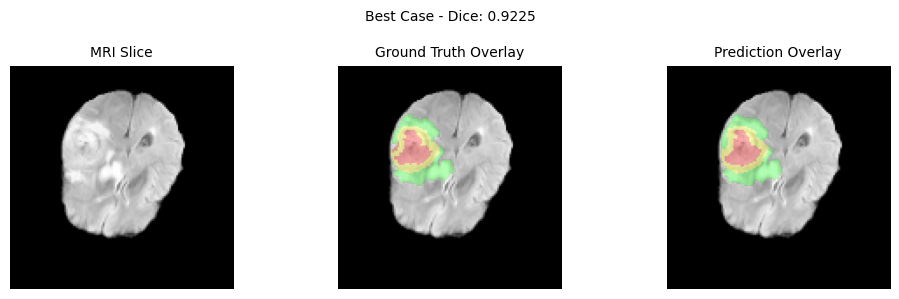

In [ ]:
for idx, score in best:
    mri = XTest[idx]
    trueMask = np.argmax(YTestCat[idx], axis=-1)
    predMask = np.argmax(YTestPred[idx], axis=-1)
    if mri.ndim == 3 and mri.shape[-1] == 3:
        mri = np.mean(mri, axis=-1)
    plotSample(mri, trueMask, predMask, f"Best Case - Dice: {score:.4f}")

---
---
## Visualise what the Model Learns
---

In this section we visualise the feature maps of the convolutional layers for the first test sample. This allows us to see how the model learnt features from the data.

To do this, we first list the names of the layers of the network.

In [ ]:
for i, layer in enumerate(modelConverge.layers):
    print(f"{i}: {layer.name}")

0: input_layer_1
1: conv2d_8
2: batch_normalization_7
3: re_lu_7
4: spatial_dropout2d_6
5: max_pooling2d_3
6: conv2d_9
7: batch_normalization_8
8: re_lu_8
9: spatial_dropout2d_7
10: max_pooling2d_4
11: conv2d_10
12: batch_normalization_9
13: re_lu_9
14: spatial_dropout2d_8
15: max_pooling2d_5
16: conv2d_11
17: batch_normalization_10
18: re_lu_10
19: up_sampling2d_3
20: concatenate_3
21: conv2d_12
22: batch_normalization_11
23: re_lu_11
24: spatial_dropout2d_9
25: up_sampling2d_4
26: concatenate_4
27: conv2d_13
28: batch_normalization_12
29: re_lu_12
30: spatial_dropout2d_10
31: up_sampling2d_5
32: concatenate_5
33: conv2d_14
34: batch_normalization_13
35: re_lu_13
36: spatial_dropout2d_11
37: conv2d_15


We select the indices for the convolutional layers in the network, which we are able to find from the list of layer names. We select the first sample from the test set to visualise.

In [ ]:
layer_indices = [1, 11, 16, 27, 33]
sampleIdx = 0

To visualise the feature maps, we loop through each convolutional layer and for that layer, we create a Keras model which takes the same input as the original model and outputs the feature maps from the convolutional layer. We pass the test sample through this model and display the layer's first eight feature maps. We do this for each convolutional layer to get the image below.

As we can see, the model is able to identify tumour regions fairly well within the first layer. However, by the final layer the map is more detailed. This is consistent with the idea that a simple model is able to discriminate between healthy and affected tissue but more complex models are required to identify tumour subregions. We can also see the compression and upsampling process which happens in a CNN designed for segmentation tasks. As we travel through the layers, the resolution of the feature maps diminishes, becoming highly pixellated, before the upsampling process reintroduces granular detail.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


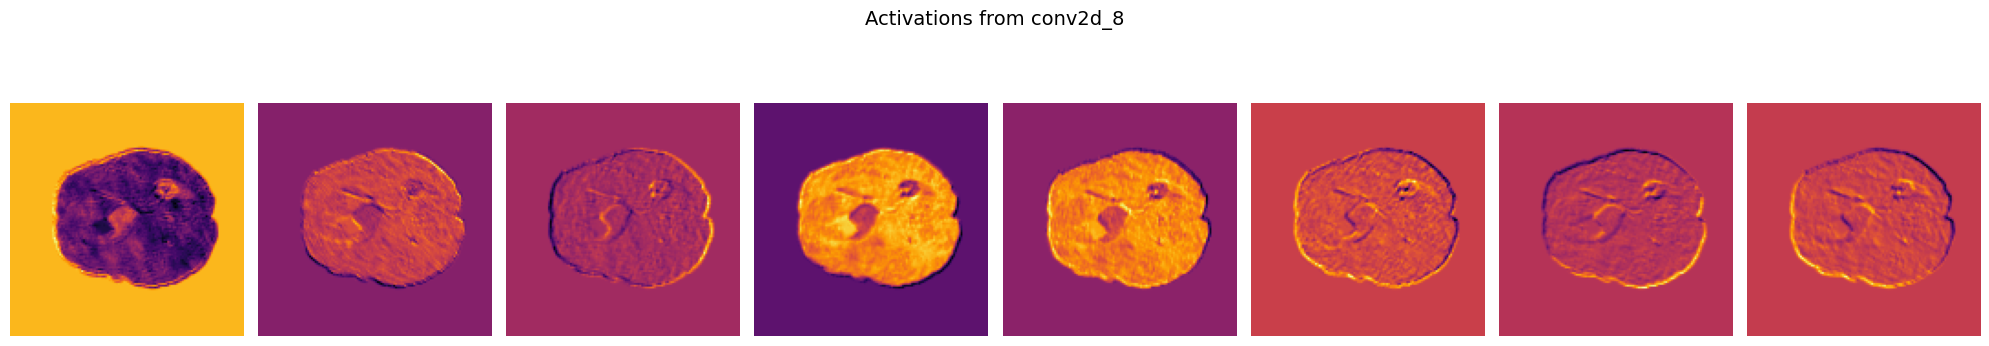

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


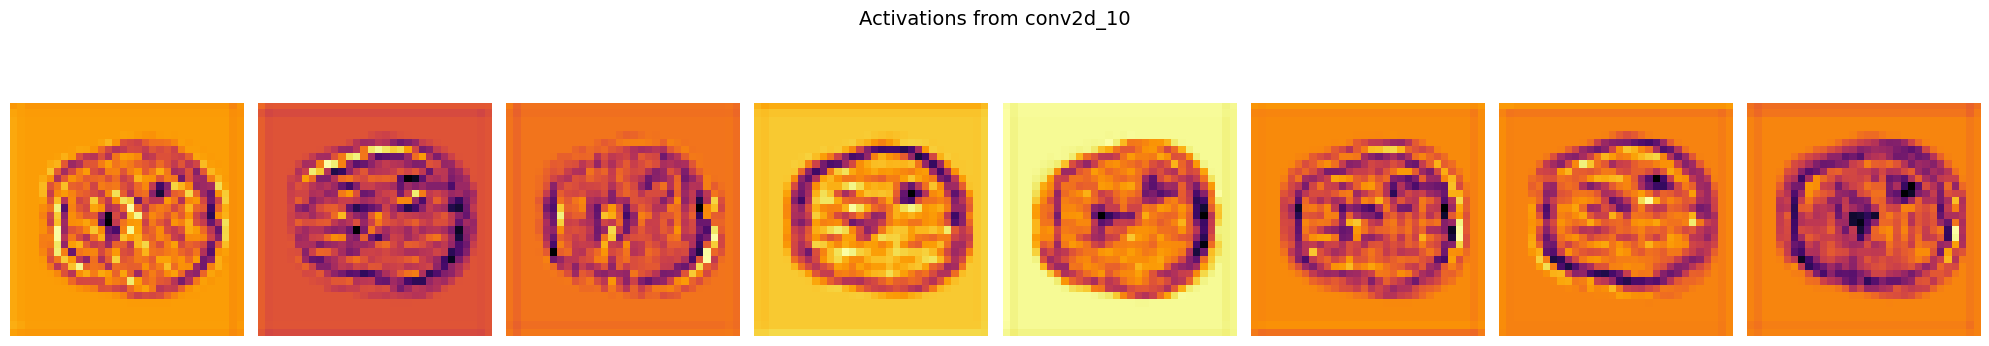

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


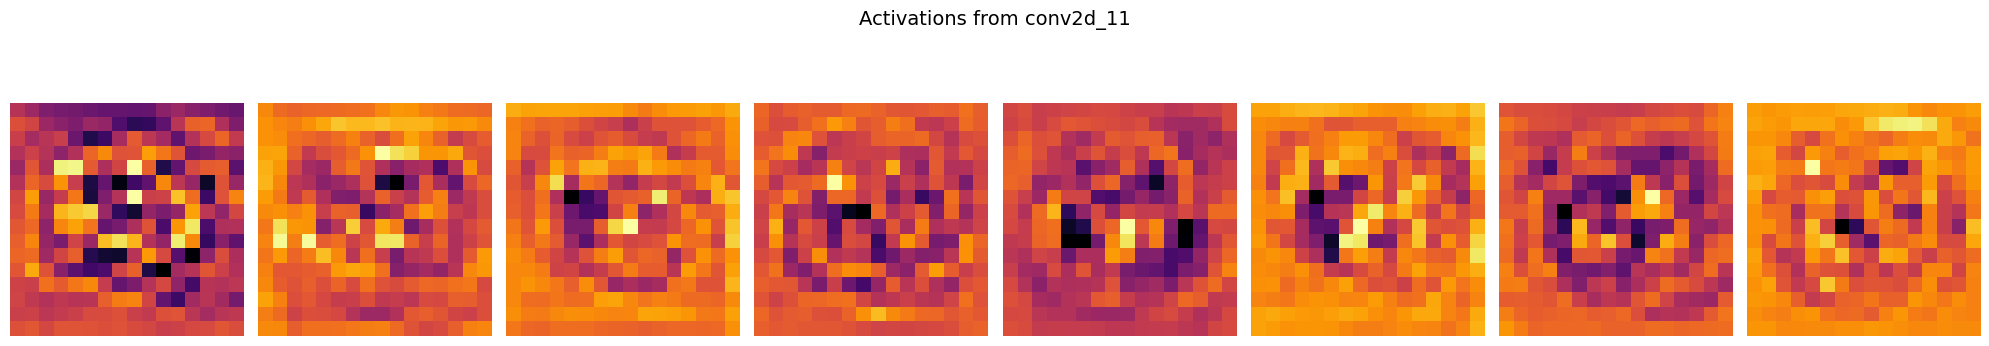

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


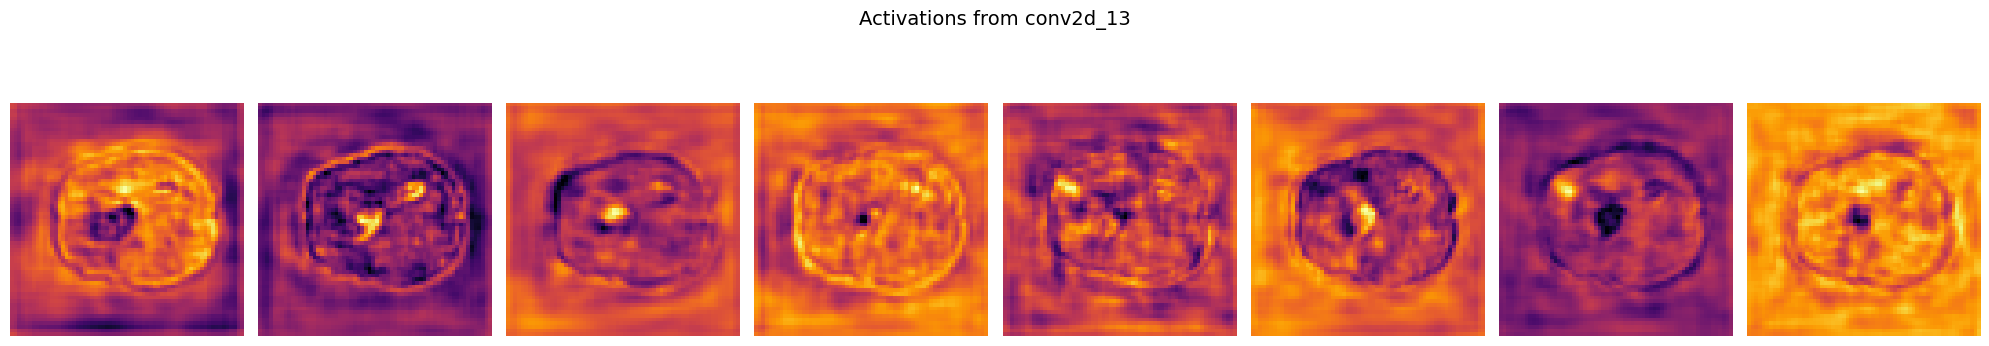

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step


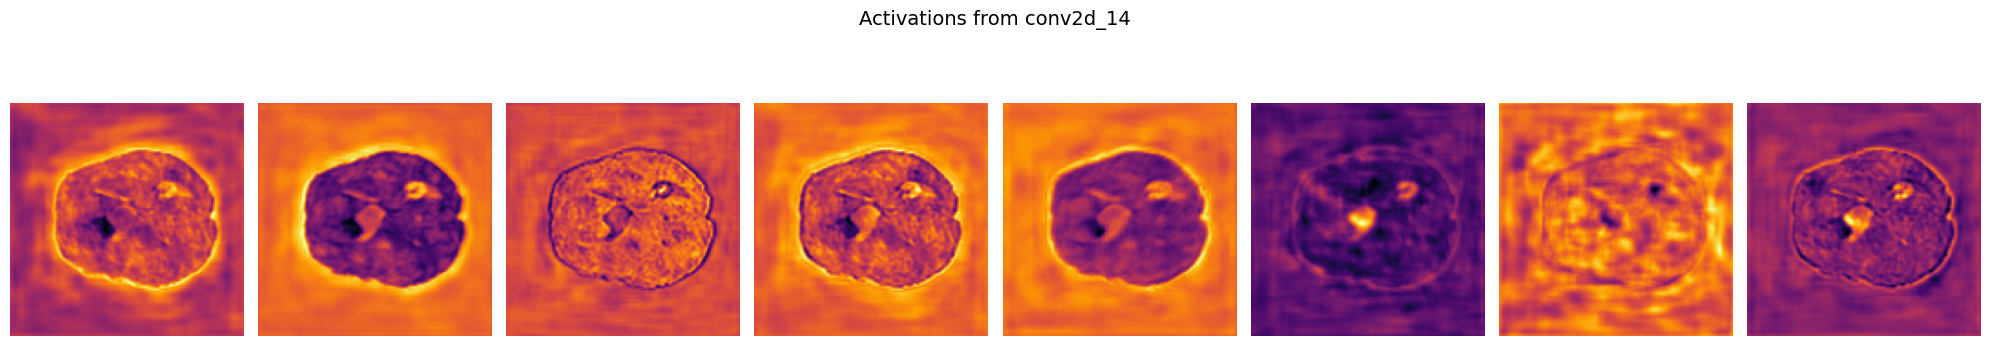

In [ ]:
for idx in layer_indices:
    layer_name = modelConverge.layers[idx].name
    featureModel = Model(inputs=modelConverge.input,
        outputs=modelConverge.layers[idx].output)
    activations = featureModel.predict(XTest[sampleIdx:sampleIdx+1])

    num_filters = min(8, activations.shape[-1])
    fig, axs = plt.subplots(1, num_filters, figsize=(20, 4))
    for i in range(num_filters):
        axs[i].imshow(activations[0, :, :, i], cmap='inferno')
        axs[i].axis("off")
    plt.suptitle(f"Activations from {layer_name}", fontsize=14)
    plt.tight_layout()
    plt.show()

---
---
# Conclusion
---

In this phase we have trained an autoencoder on the unlabelled MRI images and explored two different pretraining methods. The pretraining method without a warmup phase performed comparably with the model without unsupervised pretraining and the model with a warmup stage performed significantly worse. Overall, the results suggested that unsupervised pretraining did not improve the model's performance. This is likelye due to the fact that during pretraining, the model learns to reconstruct the backgroound region which biases the model towards learning healthy tissue. This prevents the model from being able to effectively learn the tumour regions which are minority classes.

We also used Kera Tuner to fine tune the model before scaling up the number of epochs and evaluating the model on the test set. The first round of finetuning tested different filter sizes and the number of filters per layer. The results showed that increasing the model's capacity improved performance. The second round tested different training parameters but this yieleded no performance gains. The final model, which has been built up over the three phases was evaluated on the test set and preformed relatively well. The average DICE score across all three tumour classes was 0.73, indicating a good overlap between the model's predictions and the human-annotated segmentations. The model performed best at predicting edema was effective at identifying the necrotic core and enhancing tumour with a DICE score of 0.73 and 0.72, respectively, for these regions. The precision was much higher compared to the recall, suggesting the model tended to be correct when it predicted a tumour region, but tended to incorrectly classify approximately 34% of tumour regions. This trade-off was reflected in the F1 Score of 0.75.

Finally the best and worst performing results were visualised, indicating that the model struggled to identify areas which would be difficult for the human eye to see, such as very small areas or areas where the tissue was a similar colour to healthy tissue. Areas for future research may include creating contextualised datasets for resource constrained research, such as shallow 3D segments a few slices deep as this would help the model to identify edge cases.

---
---